<a href="https://colab.research.google.com/github/blaw5/dlwpt-code/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 1 Part 1

In [15]:
from torchvision import datasets
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import datetime
data_path = "../content/drive/MyDrive/ColabNotebooks/data/hw3/"
cifar10 = datasets.CIFAR10(data_path, train = True, download = True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train = False, download = True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))
imgs_v = torch.stack([img_t for img_t, _ in cifar10_val], dim=3)
print(imgs_v.view(3, -1).mean(dim=1))
print(imgs_v.view(3, -1).std(dim=1))

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])
tensor([0.4942, 0.4851, 0.4504])
tensor([0.2467, 0.2429, 0.2616])


In [ ]:
transformed_cifar10 = datasets.CIFAR10(
  data_path, train=True, download=False,
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2470, 0.2435, 0.2616))
]))

In [ ]:
transformed_cifar10_val = datasets.CIFAR10(
  data_path, train=False, download=False,
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4942, 0.4851, 0.4504),
                          (0.2467, 0.2429, 0.2616))
]))

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
                  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8) #need to mod outputs for 10
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    t_predicted = []
    for epoch in range(1, n_epochs + 1):
      loss_train = 0.0
      for imgs, labels in train_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
      if epoch == 1 or epoch % 10 == 0:
        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))
      t_predicted.append(loss.item())
    fig = plt.figure(dpi = 100)
    step = np.linspace(0,n_epochs,n_epochs)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(step,np.array(t_predicted))
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
      correct = 0
      total = 0
      with torch.no_grad():
        for imgs, labels in loader:
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          outputs = model(imgs)
          _, predicted = torch.max(outputs, dim=1)
          total += labels.shape[0]
          correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                         shuffle=False)
model = Net().to(device = device)  
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()

2022-03-30 00:26:11.867947 Epoch 1, Training loss 2.032483955935749
2022-03-30 00:27:37.016604 Epoch 10, Training loss 1.2084328864541505
2022-03-30 00:29:12.272675 Epoch 20, Training loss 1.0205766406967818
2022-03-30 00:30:46.816966 Epoch 30, Training loss 0.9347630172129482
2022-03-30 00:32:21.592234 Epoch 40, Training loss 0.8731548704988207
2022-03-30 00:33:56.469797 Epoch 50, Training loss 0.8290206539966262
2022-03-30 00:35:31.022016 Epoch 60, Training loss 0.7951454441337025
2022-03-30 00:37:05.806761 Epoch 70, Training loss 0.7673936909650598
2022-03-30 00:38:40.758717 Epoch 80, Training loss 0.7422370425118204
2022-03-30 00:40:15.405438 Epoch 90, Training loss 0.7192055514401487
2022-03-30 00:41:49.705392 Epoch 100, Training loss 0.7009781228230737
2022-03-30 00:43:23.970976 Epoch 110, Training loss 0.6845783327546571
2022-03-30 00:44:58.219523 Epoch 120, Training loss 0.6689087371234699
2022-03-30 00:46:33.007410 Epoch 130, Training loss 0.6570860066301073
2022-03-30 00:48:0

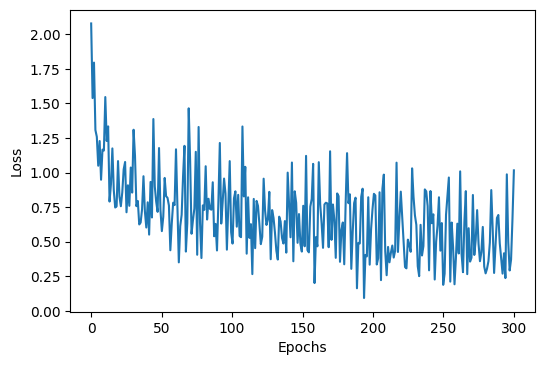

In [ ]:
x1 = training_loop(
  n_epochs=300,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,)

In [ ]:
validate(model, train_loader, val_loader)

Accuracy train: 0.76
Accuracy val: 0.60


Question 1 Part 2

In [ ]:
class ExtendedNet(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
device = (torch.device('cuda') if torch.cuda.is_available()
                  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                         shuffle=False)
extendedModel = ExtendedNet().to(device = device)  
optimizer = optim.SGD(extendedModel.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()

2022-03-30 01:16:28.363966 Epoch 1, Training loss 2.2346520416267084
2022-03-30 01:17:57.999763 Epoch 10, Training loss 1.1696371612951273
2022-03-30 01:19:37.502579 Epoch 20, Training loss 0.9203970989455348
2022-03-30 01:21:17.119639 Epoch 30, Training loss 0.8016853483055558
2022-03-30 01:22:56.384666 Epoch 40, Training loss 0.7335114594539414
2022-03-30 01:24:35.249891 Epoch 50, Training loss 0.6799268420318814
2022-03-30 01:26:13.860873 Epoch 60, Training loss 0.6410813357137963
2022-03-30 01:27:54.351152 Epoch 70, Training loss 0.6108278834149051
2022-03-30 01:29:33.154035 Epoch 80, Training loss 0.580937547775943
2022-03-30 01:31:12.095593 Epoch 90, Training loss 0.5612548763299232
2022-03-30 01:32:50.873000 Epoch 100, Training loss 0.5405965129966321
2022-03-30 01:34:29.258230 Epoch 110, Training loss 0.5215213433708377
2022-03-30 01:36:08.485282 Epoch 120, Training loss 0.5038437300440296
2022-03-30 01:37:49.071424 Epoch 130, Training loss 0.4924443285445423
2022-03-30 01:39:2

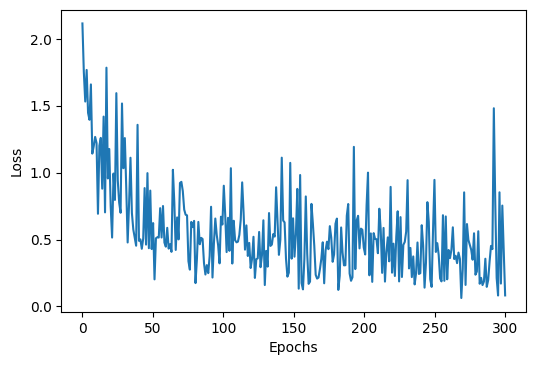

In [ ]:
x2 = training_loop(
  n_epochs=300,
  optimizer = optimizer,
  model = extendedModel,
  loss_fn = loss_fn,
  train_loader = train_loader,)

In [16]:
validate(extendedModel, train_loader, val_loader)

Accuracy train: 0.86
Accuracy val: 0.70


Problem 2 - ResNet10

(Batch Normalization included to prevent loss of gradients)

In [17]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
import datetime
data_path = "../content/drive/MyDrive/ColabNotebooks/data/hw3/"
cifar10 = datasets.CIFAR10(data_path, train = True, download = True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train = False, download = True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [25]:
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                      padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight,
                                  nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x
class ResNet10(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [26]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    t_predicted = []
    for epoch in range(1, n_epochs + 1):
      loss_train = 0.0
      for imgs, labels in train_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
      if epoch == 1 or epoch % 10 == 0:
        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))
      t_predicted.append(loss.item())
    fig = plt.figure(dpi = 100)
    step = np.linspace(0,n_epochs,n_epochs)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(step,np.array(t_predicted))
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
      correct = 0
      total = 0
      with torch.no_grad():
        for imgs, labels in loader:
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          outputs = model(imgs)
          _, predicted = torch.max(outputs, dim=1)
          total += labels.shape[0]
          correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [27]:
transformed_cifar10 = datasets.CIFAR10(
  data_path, train=True, download=False,
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2470, 0.2435, 0.2616))
]))
transformed_cifar10_val = datasets.CIFAR10(
  data_path, train=False, download=False,
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4942, 0.4851, 0.4504),
                          (0.2467, 0.2429, 0.2616))
]))
device = (torch.device('cuda') if torch.cuda.is_available()
                  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [28]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                         shuffle=False)
res10Model = ResNet10().to(device = device)  
optimizer = optim.SGD(res10Model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()

2022-03-30 02:15:55.803529 Epoch 1, Training loss 1.7147283567796887
2022-03-30 02:17:59.184753 Epoch 10, Training loss 0.8006498575439234
2022-03-30 02:20:16.718033 Epoch 20, Training loss 0.6151459962891801
2022-03-30 02:22:32.621097 Epoch 30, Training loss 0.48384183980619816
2022-03-30 02:24:49.233275 Epoch 40, Training loss 0.38739520359946333
2022-03-30 02:27:05.752026 Epoch 50, Training loss 0.3085019122094602
2022-03-30 02:29:22.352729 Epoch 60, Training loss 0.24494699627408745
2022-03-30 02:31:38.355198 Epoch 70, Training loss 0.20118539991890988
2022-03-30 02:33:55.384302 Epoch 80, Training loss 0.165445425533368
2022-03-30 02:36:11.025754 Epoch 90, Training loss 0.14822269925642806
2022-03-30 02:38:27.233262 Epoch 100, Training loss 0.12930969802467415
2022-03-30 02:40:43.763249 Epoch 110, Training loss 0.10257871691530565
2022-03-30 02:42:59.976893 Epoch 120, Training loss 0.10344537676019055
2022-03-30 02:45:16.083303 Epoch 130, Training loss 0.08903171248850711
2022-03-3

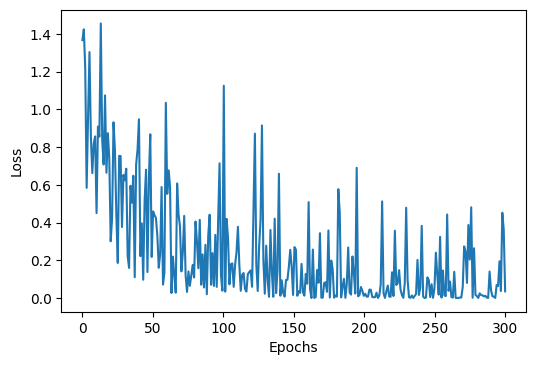

In [29]:
x3 = training_loop(
  n_epochs=300,
  optimizer = optimizer,
  model = res10Model,
  loss_fn = loss_fn,
  train_loader = train_loader,)

In [30]:
validate(res10Model, train_loader, val_loader)

Accuracy train: 0.98
Accuracy val: 0.67


Problem 2 - Weight Decay

In [31]:
def training_loop_weightDecay(n_epochs, optimizer, model, loss_fn,
                              train_loader):
    t_predicted = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
        t_predicted.append(loss.item())
    fig = plt.figure(dpi = 100)
    step = np.linspace(0,n_epochs,n_epochs)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(step,np.array(t_predicted))

In [32]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                         shuffle=False)
ResNet10WD = ResNet10().to(device = device)  
optimizer = optim.SGD(ResNet10WD.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()

2022-03-30 03:26:23.809023 Epoch 1, Training loss 1.980715816283165
2022-03-30 03:28:30.707467 Epoch 10, Training loss 0.9596872102574009
2022-03-30 03:30:51.518824 Epoch 20, Training loss 0.7472582121029534
2022-03-30 03:33:13.441469 Epoch 30, Training loss 0.6372695812941207
2022-03-30 03:35:34.137045 Epoch 40, Training loss 0.5672971831105859
2022-03-30 03:37:56.384971 Epoch 50, Training loss 0.5131424078932199
2022-03-30 03:40:17.298126 Epoch 60, Training loss 0.48922256073530984
2022-03-30 03:42:37.715655 Epoch 70, Training loss 0.4671959657498333
2022-03-30 03:44:57.802687 Epoch 80, Training loss 0.4352557459641296
2022-03-30 03:47:18.883590 Epoch 90, Training loss 0.4219330805151359
2022-03-30 03:49:39.451068 Epoch 100, Training loss 0.4105441562850457
2022-03-30 03:52:00.909084 Epoch 110, Training loss 0.41229035573847156
2022-03-30 03:54:21.932544 Epoch 120, Training loss 0.40553291801296537
2022-03-30 03:56:43.110711 Epoch 130, Training loss 0.3822313572287255
2022-03-30 03:5

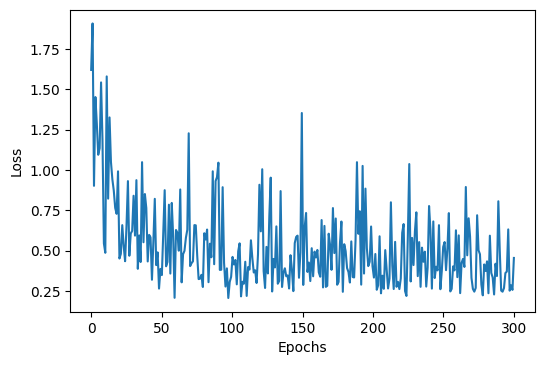

In [33]:
x4 = training_loop_weightDecay(
  n_epochs=300,
  optimizer = optimizer,
  model = ResNet10WD,
  loss_fn = loss_fn,
  train_loader = train_loader,)

In [34]:
validate(ResNet10WD, train_loader, val_loader)

Accuracy train: 0.85
Accuracy val: 0.65


Dropout with p=0.3

In [35]:
#must modify deep
class ResNet10Drop(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [36]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                         shuffle=False)
modeldrop = ResNet10Drop().to(device = device)  
optimizer = optim.SGD(modeldrop.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()

2022-03-30 04:42:16.139487 Epoch 1, Training loss 1.9642769477861313
2022-03-30 04:44:17.689890 Epoch 10, Training loss 0.8734439268441456
2022-03-30 04:46:31.795439 Epoch 20, Training loss 0.647560236589683
2022-03-30 04:48:46.238853 Epoch 30, Training loss 0.5172128145347166
2022-03-30 04:51:00.214938 Epoch 40, Training loss 0.4121347511630229
2022-03-30 04:53:14.249330 Epoch 50, Training loss 0.330474939502185
2022-03-30 04:55:28.089099 Epoch 60, Training loss 0.26730610458823423
2022-03-30 04:57:42.249855 Epoch 70, Training loss 0.21485582214144186
2022-03-30 04:59:56.271524 Epoch 80, Training loss 0.18065241148547673
2022-03-30 05:02:10.460700 Epoch 90, Training loss 0.14654561975980393
2022-03-30 05:04:24.348606 Epoch 100, Training loss 0.13736964453040335
2022-03-30 05:06:38.411689 Epoch 110, Training loss 0.13920285716257474
2022-03-30 05:08:52.491087 Epoch 120, Training loss 0.09823330463257993
2022-03-30 05:11:06.445479 Epoch 130, Training loss 0.08567353812060641
2022-03-30 

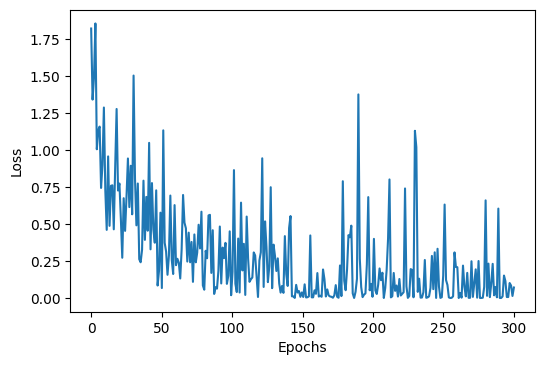

In [37]:
x5 = training_loop(
  n_epochs=300,
  optimizer = optimizer,
  model = modeldrop,
  loss_fn = loss_fn,
  train_loader = train_loader,)

In [38]:
validate(modeldrop, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.65
